In [ ]:
import json

with open('/Users/kriskasira/Documents/RiProject/archive/Batch 3/import-videos/ann/instances.json', 'r') as file:
    podaci = json.load(file)

In [ ]:
podaci['images']

[{'license': 'None',
  'file_name': 'Football batch 3.mp4_00000.jpg',
  'url': 'None',
  'height': 1080,
  'width': 1920,
  'date_captured': '2023-04-15T08:43:47.612Z',
  'id': 16640924},
 {'license': 'None',
  'file_name': 'Football batch 3.mp4_00001.jpg',
  'url': 'None',
  'height': 1080,
  'width': 1920,
  'date_captured': '2023-04-15T08:43:47.612Z',
  'id': 16640925},
 {'license': 'None',
  'file_name': 'Football batch 3.mp4_00002.jpg',
  'url': 'None',
  'height': 1080,
  'width': 1920,
  'date_captured': '2023-04-15T08:43:47.612Z',
  'id': 16640926},
 {'license': 'None',
  'file_name': 'Football batch 3.mp4_00003.jpg',
  'url': 'None',
  'height': 1080,
  'width': 1920,
  'date_captured': '2023-04-15T08:43:47.612Z',
  'id': 16640927},
 {'license': 'None',
  'file_name': 'Football batch 3.mp4_00004.jpg',
  'url': 'None',
  'height': 1080,
  'width': 1920,
  'date_captured': '2023-04-15T08:43:47.612Z',
  'id': 16640928},
 {'license': 'None',
  'file_name': 'Football batch 3.mp4_00

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd drive/MyDrive/panoptic

/content/drive/.shortcut-targets-by-id/1i1O5IzicKZOnN9ws7xZ6NJuTmO6MumG4/panoptic


In [ ]:
!pip install pycocotools

In [3]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
import cv2
from pycocotools.coco import COCO

In [ ]:
import random

def random_color():
    return [random.randint(0, 255) for _ in range(3)]

def coco_to_colored_masks(coco_annotation_file, img_dir, output_dir):
    coco = COCO(coco_annotation_file)
    img_ids = coco.getImgIds()

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        mask = np.zeros((height, width), dtype=np.uint8)
        colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
        instance_id = 1

        for ann in anns:
            ann_mask = coco.annToMask(ann)
            class_id = ann['category_id']
            unique_value = instance_id + (category_weights[class_id] * 1000)
            mask = np.maximum(mask, ann_mask * unique_value)
            color = random_color()
            colored_mask[mask == unique_value] = color
            instance_id += 1

        mask_output_path = os.path.join(output_dir, os.path.splitext(img_info['file_name'])[0] + '_mask.png')
        cv2.imwrite(mask_output_path, colored_mask)

In [ ]:
coco_annotation_file = './archive/Batch-1/Soccer/ann/instances.json'
img_dir = './archive/images/'
output_dir = './archive/images/mask'

os.makedirs(output_dir, exist_ok=True)

coco_to_colored_masks(coco_annotation_file, img_dir, output_dir)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [ ]:
import torchvision.transforms as T
from torchvision.models import ResNet50_Weights

class CustomDataset(Dataset):
    def __init__(self, root, annotation_files, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco_datasets = [COCO(annotation_file) for annotation_file in annotation_files]
        self.img_ids = []
        for coco in self.coco_datasets:
            self.img_ids.extend(list(coco.imgs.keys()))
        self.img_ids = list(set(self.img_ids))


    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        for coco in self.coco_datasets:
            if img_id in coco.imgs:
                img_info = coco.loadImgs(img_id)[0]
                ann_ids = coco.getAnnIds(imgIds=img_id)
                anns = coco.loadAnns(ann_ids)
                break

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        masks = []
        areas = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            mask = coco.annToMask(ann)
            masks.append(mask)
            areas.append(ann['area'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
        areas = torch.as_tensor(areas, dtype=torch.float32)

        image_id = torch.tensor([img_id])
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in anns], dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_ids)

# Get the model


# Training and validation code
def train():
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    device = 'cuda'

    num_classes = 8
    dataset = CustomDataset('./archive/images/', [
        './archive/Batch-1/Soccer/ann/instances.json',
        './archive/Batch-2/import-videos/ann/instances.json',
        './archive/Batch-3/import-videos/ann/instances.json'
    ], transforms=T.Compose([T.ToTensor()]))
    # dataset_test = CustomDataset('./archive/')

    data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
    # data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

    model = get_instance_segmentation_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    num_epochs = 5
    train_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            running_loss += losses.item()


        epoch_loss = running_loss / len(data_loader)
        train_losses.append(epoch_loss)
        lr_scheduler.step()

        # Model evaluation for test set (currently commented out)
        # model.eval()
        # for images, targets in data_loader_test:
        #     images = list(image.to(device) for image in images)
        #     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #     with torch.no_grad():
        #         prediction = model(images, targets)

    print("Training complete")
    return model, train_losses

In [6]:
def get_instance_segmentation_model(num_classes):
    backbone = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
    backbone.out_channels = 2048

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )

    model = MaskRCNN(backbone,
                     num_classes=num_classes,
                     rpn_anchor_generator=anchor_generator,
                     box_roi_pool=roi_pooler)

    return model

In [ ]:
model, losses = train()
torch.save(model.state_dict(), "./output/mask_rcnn1.pth")

loading annotations into memory...
Done (t=1.25s)
creating index...
index created!
loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
loading annotations into memory...
Done (t=2.13s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 65.2MB/s]


Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Training complete


In [4]:
categories = {
    1: "Player",
    2: "Ball",
    3: "Goal Line",
    4: "Field",
    5: "Background",
    6: "Referee",
    7: "Football Pitch Line",
}

Background
Field
Referee
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player
Player


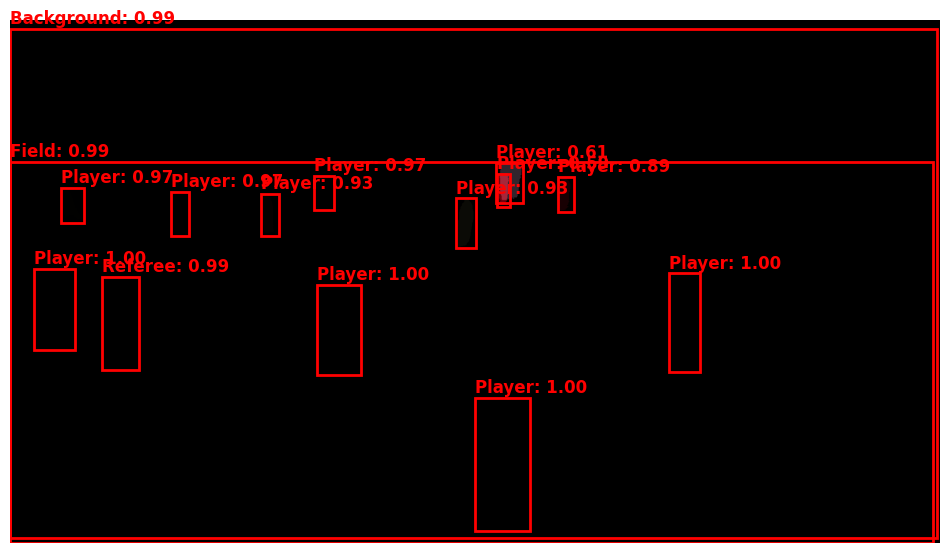

In [8]:
import random
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image
import numpy as np
from torchvision.models import ResNet50_Weights


def load_model(model_path, num_classes):
    model = get_instance_segmentation_model(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    image = Image.open(image_path).convert("RGB")

    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        prediction = model(image_tensor.to(device))

    return image, prediction

model = load_model('./output/mask_rcnn1.pth', 8)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

In [40]:
def set_priorities(prediction, priorities):
    predictions_with_priorities = []
    for element in range(len(prediction[0]['boxes'])):
        box = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label_id = int(prediction[0]['labels'][element].cpu().numpy())
        mask = prediction[0]['masks'][element, 0].cpu().numpy()
        priority = priorities.get(label_id, 0)
        predictions_with_priorities.append((priority, box, score, label_id, mask))

    predictions_with_priorities.sort(key=lambda x: x[0])
    return predictions_with_priorities

def predict_and_visualize(image_path, model, device, draw_mask = True, draw_box = True):

    image, prediction = predict(model, image_path, device)
    # setting model priorities for properly mask drawing
    priorities = {
        1 : 6, # player
        2 : 7, # ball
        3 : 4, # goal line
        4 : 2, # field
        5 : 1, # background
        6 : 5, # refree
        7 : 3, # pitch line
        0 : 0
    }


    predictions_with_priorities = set_priorities(prediction, priorities)

    combined_mask = np.zeros_like(image, dtype=np.float32)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    if draw_mask:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                mask = mask > 0.5
                random_color = np.random.rand(3)
                colored_mask = np.zeros((*mask.shape, 3))
                colored_mask[mask] = random_color
                combined_mask[mask] = random_color


        combined_mask = np.clip(combined_mask, 0, 1)
        ax.imshow(combined_mask, alpha=0.5)

    if draw_box:
        for priority, box, score, label_id, mask in predictions_with_priorities:
            label = categories.get(label_id, 'Unknown')

            if score > 0.5:
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(box[0], box[1] - 10, f'{label}: {score:.2f}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

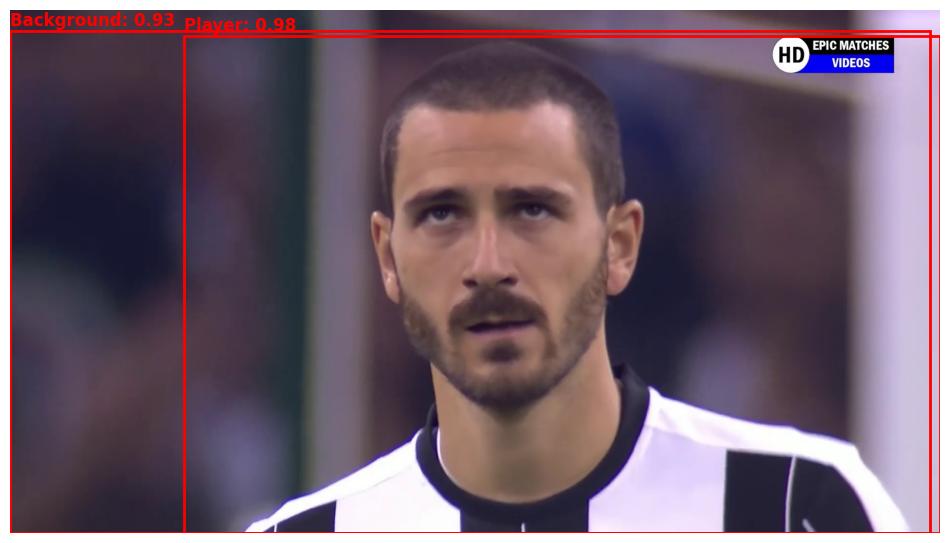

In [44]:
predict_and_visualize("./archive/images/Football batch 1.mp4_00001.jpg", model, device, draw_box=True, draw_mask=False)